# DSCI100 Project: Planning Stage (Individual)

### Predicting Usage of a Video Game Research Server

- Name: Eva Yarantseva, Section: 109 
- Student Number: 32172173

In [128]:
# loading all of the packages:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(ggplot2)

## (1) Data Description 

These two datasets were collected through a free MineCraft server set up by a CS group at UBC lead by Frank Wood. The research group records the actions the players take within the server, including gameplay, speech, and key presses (see https://plaicraft.ai/faq/ethics). 

#### Dataset (a): players.csv

This dataset contains 196 observations that have 7 variables: 
- **experience**: character variable; the skill level of the player (Beginner, Amature, Pro or Veteran).
- **subscribe**: TRUE/FALSE logical variable; whether or not a player is subscribed to a game-related newspaper.
- **hashedEmail**: character variable; the user's hashed email as a string of letters and numbers. 
- **played_hours**: numerical variable, the number of hours played.
- **name**: character variable; the first name of the player.
- **gender**: character variable; gender of player; Male, Female, Non-binary, Two-spirited, Agender, and to those who did not share their gender ("Prefer not say").
- **Age**: integer variable; age of the player.

*Summary statistics: 
- The mean age of players is 21.14 years old, with the median being 19.00 years old.
- The average session is 5.85 hrs long.

*Computed in project_extra.ipynb

Problems with the dataset: 
- Type of variable: have to convert the character variables to factors before being able to tidy the data (ie. the gender variable).
- The played_hours variable does not specify if this is the total hours played overall, per week, etc.

#### Dataset (b): sessions.csv

This dataset contains 1535 observations that have 5 variables:
- **hasedEmail**: character variable; stores the user's hashed email.
- **start_time**: character variable; the starting date and 24 hr time of the playing session.
- **end_time**: character variable; the ending date and 24 hr time of the playing session.
- **original_start_time**: numerical variable; the start of the playing session as a UNIX timestamp (milliseconds).
- **original_end_time**: numerical variable; stores the end of the playing session as a UNIX timestamp (milliseconds).

*Summary statistics: 
- The median start time in UNIX timestamp is 1.719e+12.
- The median end time in UNIX timestamp is 1.719e+12.

*Computed in project_extra.ipynb

Problems with the dataset: 
- the start_time and end_time variables have both the date start time and the 24hr time of when the player started their gaming session as one observation instead of separate.
- The UNIX time stamp is in milliseconds instead of seconds.

## (2) Questions

- **Broad question addressed**: Question 2: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

- **Specific question**: Can the age and playtime of a player predict the gender of the player in player.csv?

The dataset I will be using is player.csv. I will use the age and played_hours variables to predict the "kind" (gender) of player within the dataset. As initial wrangling, I will convert the gender variable character to a factor. I will filter out the individuals who did not report their gender.

## (3) Exploratory Data Analysis and Visualization

In [129]:
#Loading the dataset into notebook

players <- read_csv("players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Performin minimal wrangling

In [130]:
# Tidying the data

# Converting the gender variable into a factor
players <- players |>
    mutate(gender = as.factor(gender))

In [131]:
# Filtering out "Prefer not to say"

players <- players |>
    filter(gender != "Prefer not to say")

### Table 1: Mean values of each quantitative variable in the players.csv data set

In [132]:
# the mean hours played

players |>
  summarise(mean_hours = mean(played_hours, na.rm = TRUE))

# the mean age

players |>
  summarise(mean_age = mean(Age, na.rm = TRUE))

mean_hours
<dbl>
6.171351


mean_age
<dbl>
20.9071


|  Mean Played Hours  | Mean Age |
|----------|-----|
| 6.17    | 20.91  | 



### Exploratory Visualizations of the Data

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


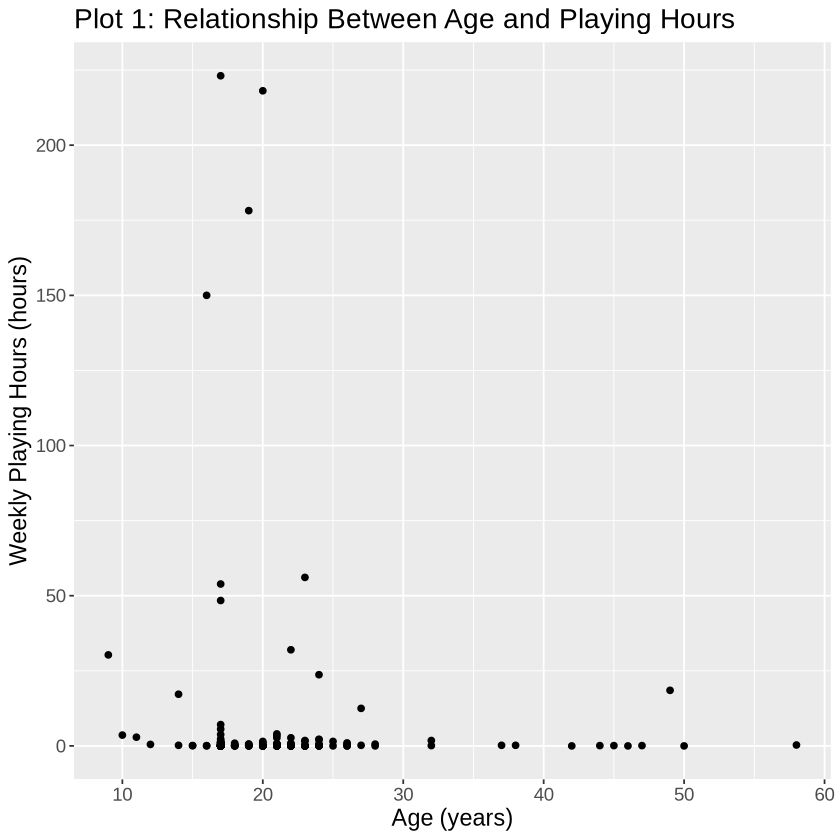

In [133]:
# Exploring the relationship between age and hours played

ggplot(data = players, aes(x = Age, y = played_hours)) +
    geom_point() +
    labs(
        title = "Plot 1: Relationship Between Age and Playing Hours",
        x = "Age (years)",
        y = "Weekly Playing Hours (hours)",
        ) + 
    theme(text = element_text(size = 14))

In Plot 1, there is a cluster of players in the bottom left corner (between ages 10-30, and 0-50 hours). The four outliers that have a range of 150-225 hours played are between 15-20 years old. The players that are older than 30 have less than 25 hours played in the server. 

There is an unbalance in data: the K-NN model may have trouble making predictions due to the lack of data on the top right hand side of the plot (people who are older than 30 and play more than 25 hours).

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


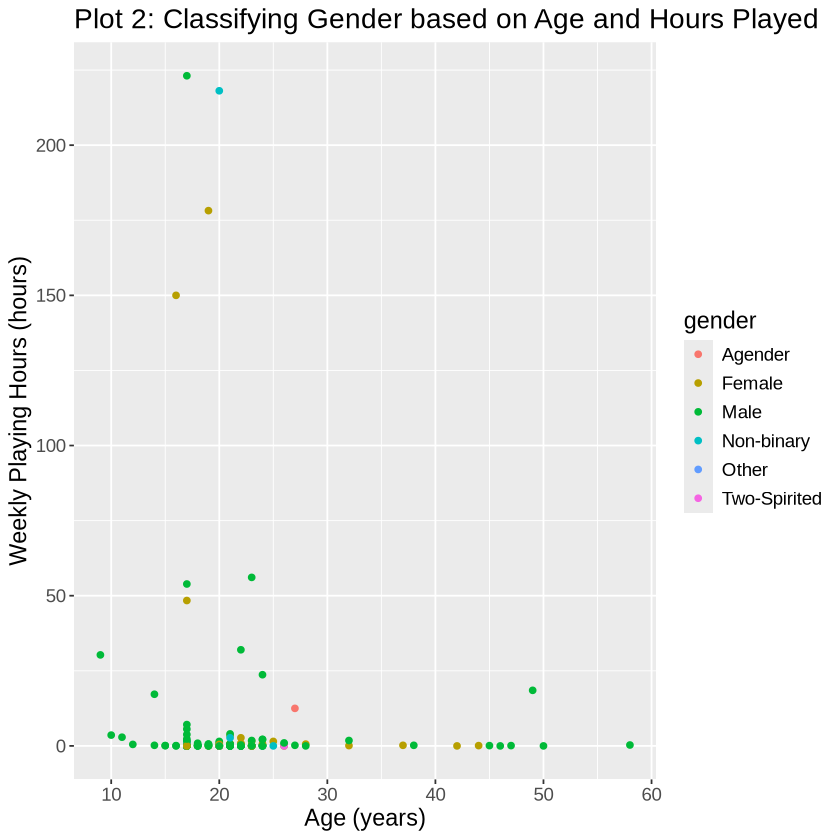

In [134]:
# Seeing if there are clustsers points that indicate gender:

ggplot(data = players, aes(x = Age, y = played_hours, color = gender)) +
    geom_point() +
    labs(
        title = "Plot 2: Classifying Gender based on Age and Hours Played",
        x = "Age (years)",
        y = "Weekly Playing Hours (hours)",
        ) + 
    theme(text = element_text(size = 14))

In Plot 2, there is a disproportionate amount of players who are male, and a lack of data from the other genders. This can cause the K-NN model to misclassify the prediction due to the lack of clustering from the genders that are not male, ie. the model may classify someone as male because there are more observations that are male.

In [135]:
# Number of observations in each gender category:

players |>
    count(gender)

gender,n
<fct>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Other,1
Two-Spirited,6


This table confirms that there is a large amount of data supplied by the male gender and a lack from the others.

## (4) Methods and Plan

I will be using the K-NN classification model to predict gender from age and hours played. This model is appropriate as the two prediction variables I will be using (age and hours played) are both continuous. This will allow me to use the straight-line distance between a new observation and the closest neighbours to predict the gender (a categorical variable). To ensure the explanatory variables have equal contribution to the model's prediction abilities, they will have to be scaled and centered (currently, the played_hours has a much larger range of values than age). The limitations of this model is that it is sensitive to the extreme outliers, and with the current dataset may not be able to predict gender properly due to the lack of data from non-male genders. After scaling and centering the dataset, it will be randomly split to test the model, into 75% for training and 25% for testing. I will use cross-validation (10-fold) to select the best model, with the appropriate number of neighbours (k). 